In [8]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import os

### Experiment settings

In [9]:
def small_setting():
    # SMALL setting experiments
    setting_name = 'small'
    common = {'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'repetitions': 1, 'architecture': '20_20'}
    param_groups = {
        'sgd':
        [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.1, 'epochs': 100, **common}],

        'frankwolfe':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'p': 2.0, 'R': 100.0, 'gamma': 0.01, 'ro': 0.6,
         'epochs': 200, **common}],

        'adam':
        [{'optimizer': 'adam', 'train_batch_size': 1000, 'p': 2.0, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
         'epochs': 200, **common}],
    }
    return setting_name, common, param_groups

In [10]:
def medium_setting():
    # medium setting
    setting_name = 'medium_auto'
    common = {'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
    param_groups = {
        'sgd':
        [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': lr, 'epochs': 100, **common}
         for lr in [0.1, 0.01, 0.001, 0.0001]],

        'frankwolfe_stochastic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': gamma, 'ro': ro,
         'epochs': 100, **common} for gamma in [-1.] + [0.1, 0.5, 1.]
         for ro in [-1.] + list(np.linspace(0, 1, 3))],

            'frankwolfe_deterministic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': gamma, 'ro': 1.0,
         'epochs': 500, **common} for gamma in [-1.] + [0.1, 0.3, 0.5]],

        'adam':
        [{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': lr, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
         'epochs': 100, **common} for lr in [0.1, 0.01, 0.001, 0.0001]]
    }
    return setting_name, common, param_groups

In [11]:
def big_setting():
    # BIG setting
    setting_name = 'big'
    common = {'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
    param_groups = {
        'sgd':
        [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': lr, 'epochs': 1000, **common}
         for lr in [1., 0.5, 0.1, 0.05]],

        'frankwolfe_stochastic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': gamma, 'ro': ro,
         'epochs': 1000, **common} for gamma in [-1.] + [0.1, 0.5]
         for ro in [-1.] + [0.1, 0.3, 0.5]],

        'frankwolfe_deterministic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': gamma, 'ro': 1.0,
         'epochs': 1000, **common} for gamma in [-1.] + [0.1, 0.5]],

        'adam':
        [{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': lr, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
         'epochs': 1000, **common} for lr in [0.01, 0.001, 0.0001]]
    }
    return setting_name, common, param_groups

In [40]:
def batch_size_setting():
    # Medium 2 setting (batch size effect)
    setting_name = 'medium2'
    common = {'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
    batches = [1000, 5000, 10000, 60000]
    param_groups = {
        'sgd':
        [{'optimizer': 'sgd', 'train_batch_size': bs, 'learning_rate': 1.0, 'epochs': 1000, **common}
         for bs in batches],

        'frankwolfe_stochastic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': bs, 'R': 20.0, 'gamma': -1.0, 'ro': -1.0,
         'epochs': 1000, **common} for bs in batches],

        'frankwolfe_deterministic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': -1.0, 'ro': 1.0,
         'epochs': 5000, **common}],

        'adam':
        [{'optimizer': 'adam', 'train_batch_size': bs, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
         'epochs': 1000, **common} for bs in batches]
    }
    return setting_name, common, param_groups

Choosing a setting

In [41]:
#R = small_setting()
#R = medium_setting()
#R = big_setting()
R = batch_size_setting()

In [42]:
# name of the setting, common parameters, parameter groups, all parameters
setting_name, common, param_groups = R
parameters = [x for group in param_groups.values() for x in group]

In [43]:
def varying_for_optim(d):
    """ What changes for optimizer? """
    d0 = d[0]
    keys = set()
    for v in d:
        for key, val in v.items():
            if d0[key] != val:
                keys.add(key)
    return list(keys)

# group -> what changes
varying = {group: varying_for_optim(param_groups[group]) for group in param_groups.keys()}

print(varying)

{'sgd': ['train_batch_size'], 'frankwolfe_stochastic': ['train_batch_size'], 'frankwolfe_deterministic': [], 'adam': ['train_batch_size']}


In [44]:
def print_nice(y):
    if isinstance(y, float):
        return str(round(y, 10))#'%.2g' % y
    return str(y)

In [45]:
def print_one(**kwargs):
    return('python experiment.py ' + " ".join(['--' + x + ' ' + print_nice(y) for x, y in kwargs.items()]) + ' &')

In [46]:
# arguments in the correct order

f = open('experiment.py', 'r').readlines()

args_in_order = []
for l in f:
    k = 'parser.add_argument(\'--'
    if l.startswith(k):
        args_in_order.append(l[len(k):].split('\'')[0])

In [47]:
def get_file(**kwargs):
    return ("_".join([x + '-' + print_nice(kwargs[x] if x in kwargs else None) for x in args_in_order])+'.output')

In [48]:
fn = 'run_' + setting_name + '.sh'
out = open(fn, 'w')
print('OUTPUT: ' + fn)

def write_to_out(s):
    print(s)
    out.write(s + '\n')

it = 0
for params in parameters:
    if it % 6 == 0:
        write_to_out('pids=""')
    write_to_out(print_one(**params))
    #print('echo aba; sleep 3 &')
    print('pids="$pids $!"')
    write_to_out('sleep 5')
    
    if it % 6 == 5:
        write_to_out('wait $pids')
        write_to_out('sleep 5')
    it += 1
it = len(parameters)
print('Total runs: ', it * common['repetitions'])
print('Total time: ', common['repetitions'] * 5 * it / 4 / 60)

out.close()

OUTPUT: run_medium2.sh
pids=""
python experiment.py --optimizer sgd --train_batch_size 1000 --learning_rate 1.0 --epochs 1000 --image_side 5 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions 10 --architecture 20_10 &
pids="$pids $!"
sleep 5
python experiment.py --optimizer sgd --train_batch_size 5000 --learning_rate 1.0 --epochs 1000 --image_side 5 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions 10 --architecture 20_10 &
pids="$pids $!"
sleep 5
python experiment.py --optimizer sgd --train_batch_size 10000 --learning_rate 1.0 --epochs 1000 --image_side 5 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions 10 --architecture 20_10 &
pids="$pids $!"
sleep 5
python experiment.py --optimizer sgd --train_batch_size 60000 --learning_rate 1.0 --epochs 1000 --image_side 5 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions 10 --architecture 20_10 &
pids="$pids $!"
sleep 5
python experiment.py --optimizer frankwolfe --train_batch_size 1000 --R 20.0 --gamma -1

In [21]:
def arr_of_dicts_to_dict_of_arrays(arr):
    """ Array of dicts to dict of arrays """
    all_keys = arr[0].keys()
    return {key: [v[key] for v in arr] for key in all_keys}

In [22]:
def shorten_name(n):
    """ Shorten aba_caba to a_c """
    return '_'.join([x[:2] if len(x) else '' for x in n.split('_')])

def shorten_dict(d, filename = False):
    """ Shorten dictionary into a string """
    if filename:
        return '_'.join([shorten_name(x) + '-' + str(y) for x, y in d.items()])
    if len(d) == 1:
        return list(d.values())[0]
    return ', '.join([shorten_name(x) + ': ' + str(y) for x, y in d.items()])

In [23]:
def process_dict(d, do_plot, name):
    """ Process one dictionary from  file, return key metrics or plot them """
    d0 = d
    d = arr_of_dicts_to_dict_of_arrays(d)
    all_keys = d.keys()
    metrics = d
    
    results = {key: [] for key in all_keys}
    results['hessian_eigens_mean'] = []
    results['hessian_eigens_Max'] = []
    del results['hessian_eigens']
    
    for i in range(len(d0)):
        for key, val in metrics.items():
            if key == 'hessian_eigens':
                eigens = val[i]
                results['hessian_eigens_mean'].append(np.mean(eigens))
                results['hessian_eigens_Max'].append(np.max(eigens))
            elif isinstance(val[i], list):
                results[key].append(val[i][-1]) # appending LAST loss/accuracy
            else:
                results[key].append(val[i])
    
    if do_plot:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('loss', color='b')
        ax1.tick_params('y', colors='b')
        
        ax2.set_ylabel('accuracy', color='r')
        ax2.tick_params('y', colors='r')
        
        for i in range(len(d0)):
            ax1.plot(metrics['train_loss'][i], alpha = 0.3, label = 'train_loss', color = 'b')
            ax1.plot(metrics['test_loss'][i], '--', alpha = 0.3, label = 'test_loss', color = 'b')

            ax2.plot(metrics['train_acc'][i], alpha = 0.3, label = 'train_acc', color = 'r')
            ax2.plot(metrics['test_acc'][i], '--', alpha = 0.3, label = 'test_acc', color = 'r')

        fig.tight_layout()
        #fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
        plt.savefig('figures/' + name + '.eps', bbox_inches = 'tight')
        plt.show()

    return results

In [24]:
def process_file(f, name, do_plot = False):
    """ Process one file """
    if not os.path.isfile(f):
        print('!!! File  missing ' + f)
        return
    
    content = open(f, 'r').read()
    if content.startswith('Nothing['):
        print('!!! File  is empty')
        return
    
    try:
        d = eval(content)
        return process_dict(d, do_plot, name)
    except:
        print('!!! File  cannot be processed')
        return None
    #return d

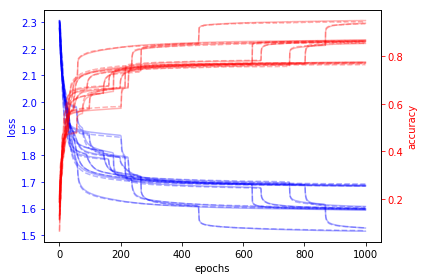

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 1.0, 'epochs': 1000, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
{'train_loss': [1.6884543, 1.6082683, 1.600035, 1.5957309, 1.6849654, 1.5272888, 1.5154456, 1.6854458, 1.594999, 1.599714], 'test_loss': [1.6929057, 1.6059177, 1.6003788, 1.5980059, 1.6847953, 1.5281516, 1.5176998, 1.6891398, 1.5986236, 1.6030881], 'train_acc': [0.77071667, 0.8548833, 0.86408335, 0.8682333, 0.7748333, 0.94015, 0.95136666, 0.77585, 0.86908334, 0.8634833], 'test_acc': [0.7656, 0.856, 0.8628, 0.8651, 0.774, 0.9372, 0.9459, 0.7703, 0.8633, 0.8586], 'p_norm': [28.624853, 29.409008, 28.224855, 31.436666, 27.921406, 31.368954, 33.7347, 27.452381, 31.648401, 30.49707], 'hessian_eigens_mean': [0.0010722098594239994, 0.0012274588694080786, 0.0009746465271682386, 0.0012993486258851081, 0.0009731339594235693, 0.0014504611305185447, 0.0015353556968546918, 0.0009530528979364593, 0.0013432

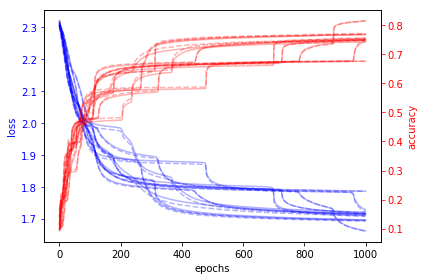

{'optimizer': 'sgd', 'train_batch_size': 5000, 'learning_rate': 1.0, 'epochs': 1000, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
{'train_loss': [1.7142386, 1.7858977, 1.7097917, 1.727955, 1.7151349, 1.7205253, 1.6952256, 1.6620471, 1.6962006, 1.716851], 'test_loss': [1.7129295, 1.7858624, 1.707018, 1.7220162, 1.7091435, 1.7143096, 1.6925414, 1.660517, 1.6934206, 1.7172701], 'train_acc': [0.75035, 0.67675, 0.75516665, 0.74565, 0.74983335, 0.7431333, 0.76875, 0.81545, 0.7687333, 0.75018334], 'test_acc': [0.7514, 0.6761, 0.7571, 0.7525, 0.7546, 0.7501, 0.7723, 0.8169, 0.7699, 0.7475], 'p_norm': [20.97804, 19.96577, 20.319695, 19.169624, 21.600769, 21.02969, 20.52581, 20.704035, 20.448399, 20.610874], 'hessian_eigens_mean': [0.0006698335931828473, 0.0005741816560940862, 0.000662059640555797, 0.0008542056179370689, 0.0007791610641322348, 0.0007285962127259225, 0.0007313788891284455, 0.0011063532524184301, 0.000767973024546

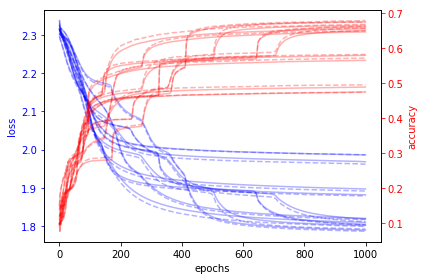

{'optimizer': 'sgd', 'train_batch_size': 10000, 'learning_rate': 1.0, 'epochs': 1000, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
{'train_loss': [1.8092456, 1.8180656, 1.7892356, 1.9680539, 1.8969086, 1.8012627, 1.8816466, 1.9862564, 1.8199974, 1.8042337], 'test_loss': [1.79889, 1.8111061, 1.7861594, 1.961708, 1.8915431, 1.7920619, 1.8788573, 1.9863954, 1.8166944, 1.802854], 'train_acc': [0.6544833, 0.6497667, 0.67406666, 0.48796666, 0.56413335, 0.6638333, 0.57848334, 0.47401667, 0.64523333, 0.6598333], 'test_acc': [0.6667, 0.6565, 0.678, 0.4942, 0.5706, 0.6729, 0.5808, 0.4732, 0.6481, 0.6607], 'p_norm': [18.168169, 16.850761, 17.281776, 15.631549, 16.986618, 17.177032, 16.527338, 15.453764, 18.289461, 17.375809], 'hessian_eigens_mean': [0.0007992525775234469, 0.0006037724793546217, 0.00047082968811753396, 0.0004392553611602603, 0.000597281363048154, 0.0005699408702696775, 0.000558309773319605, 0.0004990304553207625, 

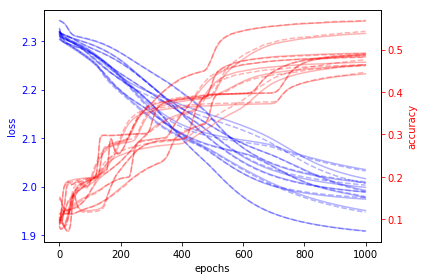

{'optimizer': 'sgd', 'train_batch_size': 60000, 'learning_rate': 1.0, 'epochs': 1000, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
{'train_loss': [1.9890667, 2.0164256, 1.9776675, 1.9508867, 2.00814, 1.9923232, 1.9742602, 2.03522, 1.9986737, 1.9088117], 'test_loss': [1.9887255, 2.0067456, 1.979609, 1.9472512, 2.0099952, 1.9903907, 1.9773039, 2.032352, 2.0032651, 1.9082078], 'train_acc': [0.48305, 0.46433333, 0.48861668, 0.53851664, 0.46396667, 0.48733333, 0.49196666, 0.44313332, 0.47066668, 0.5674667], 'test_acc': [0.4819, 0.4756, 0.4853, 0.5434, 0.4617, 0.4895, 0.4905, 0.4467, 0.4649, 0.569], 'p_norm': [12.723334, 12.57871, 12.696756, 13.008567, 12.715397, 12.704652, 12.893553, 12.718089, 12.802679, 13.3743725], 'hessian_eigens_mean': [0.0006722907971867872, 0.0008632099328597584, 0.0007488074061031494, 0.0010197921943786222, 0.0007336439619446062, 0.0007142195289850783, 0.0005990864242968838, 0.000747336500248253, 0.

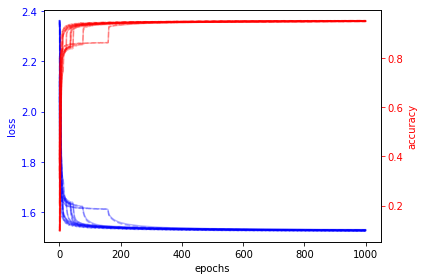

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1.0, 'ro': -1.0, 'epochs': 1000, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
{'train_loss': [1.5269021, 1.5284302, 1.5288001, 1.5277836, 1.5289937, 1.5253333, 1.5265898, 1.5303448, 1.5274212, 1.5288465], 'test_loss': [1.5253764, 1.5261168, 1.527249, 1.5258446, 1.5267823, 1.5240692, 1.5238477, 1.5282627, 1.5263373, 1.5274233], 'train_acc': [0.94983333, 0.9482833, 0.9477, 0.9492, 0.94838333, 0.95065, 0.9507333, 0.9472833, 0.94838333, 0.94853336], 'test_acc': [0.9495, 0.9504, 0.9484, 0.9497, 0.9494, 0.9505, 0.951, 0.9488, 0.9483, 0.9466], 'p_norm': [19.305296, 19.387981, 19.234804, 19.268845, 19.27935, 19.347189, 19.199442, 19.330872, 19.29351, 19.282495], 'hessian_eigens_mean': [0.0015324011336927915, 0.0012604895346567855, 0.0015412648518802214, 0.0016366789707329568, 0.0015535472200341076, 0.0013203940568939012, 0.0017521857145928058, 0.0014698

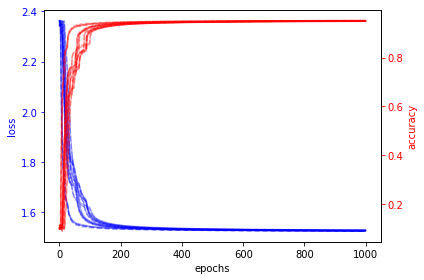

{'optimizer': 'frankwolfe', 'train_batch_size': 5000, 'R': 20.0, 'gamma': -1.0, 'ro': -1.0, 'epochs': 1000, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
{'train_loss': [1.527362, 1.5259589, 1.5283172, 1.5271806, 1.52716, 1.5264297, 1.5261678, 1.5268667, 1.5274342, 1.5262771], 'test_loss': [1.5238137, 1.5244408, 1.5263712, 1.5252811, 1.5250391, 1.5254794, 1.5238582, 1.5254264, 1.5254121, 1.5244269], 'train_acc': [0.9496833, 0.95155, 0.94816667, 0.9494, 0.94965, 0.9503667, 0.94981664, 0.949, 0.94988334, 0.94948334], 'test_acc': [0.9517, 0.9507, 0.9504, 0.9493, 0.9487, 0.9514, 0.9512, 0.9495, 0.95, 0.9512], 'p_norm': [19.530088, 19.574598, 19.41757, 19.533632, 19.544214, 19.545431, 19.44838, 19.48456, 19.419367, 19.571684], 'hessian_eigens_mean': [0.0015395638882878767, 0.0014436134256066446, 0.0017497495113098778, 0.0015757159681314237, 0.0014241448647351591, 0.0015021863521770395, 0.0016567730435305794, 0.00145525141705

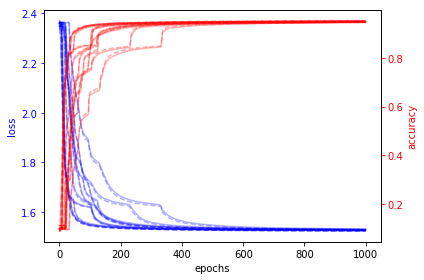

{'optimizer': 'frankwolfe', 'train_batch_size': 10000, 'R': 20.0, 'gamma': -1.0, 'ro': -1.0, 'epochs': 1000, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
{'train_loss': [1.5267636, 1.5290691, 1.5293678, 1.5313479, 1.5278081, 1.5261141, 1.5299852, 1.5259765, 1.5299518, 1.5261045], 'test_loss': [1.523936, 1.5277215, 1.527708, 1.5297989, 1.5263226, 1.525614, 1.529177, 1.5228621, 1.5279094, 1.5246304], 'train_acc': [0.94998336, 0.94733334, 0.94691664, 0.9459, 0.94776666, 0.95108336, 0.9467833, 0.9500667, 0.94698334, 0.95], 'test_acc': [0.9522, 0.946, 0.9476, 0.9457, 0.9488, 0.9499, 0.9456, 0.953, 0.9467, 0.9506], 'p_norm': [19.623762, 19.336304, 19.458063, 19.140388, 19.610952, 19.66818, 19.50207, 19.608313, 19.499027, 19.577736], 'hessian_eigens_mean': [0.0013837775486496221, 0.001330034913958902, 0.0013735170443077364, 0.001343418861507658, 0.0012779547709021026, 0.0013732294602915992, 0.0017535936962278544, 0.0013333414

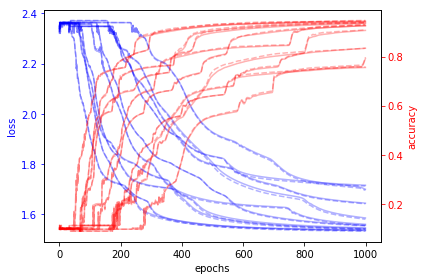

{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': -1.0, 'ro': -1.0, 'epochs': 1000, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
{'train_loss': [1.7148474, 1.5843412, 1.536552, 1.5590024, 1.6987404, 1.5446317, 1.5341914, 1.5549827, 1.5419174, 1.643337], 'test_loss': [1.7114092, 1.5792482, 1.5340885, 1.5542883, 1.6942989, 1.5408306, 1.5312173, 1.552504, 1.5387247, 1.6407893], 'train_acc': [0.7553167, 0.9061, 0.94128335, 0.9249333, 0.7920167, 0.93413335, 0.9439833, 0.9256, 0.93731666, 0.83358335], 'test_acc': [0.7577, 0.9082, 0.9435, 0.9298, 0.7967, 0.9368, 0.9467, 0.9287, 0.9393, 0.8333], 'p_norm': [16.514137, 15.67704, 19.071407, 16.910284, 14.663057, 18.124853, 19.003622, 17.191471, 18.365137, 15.57015], 'hessian_eigens_mean': [0.0010138878076294652, 0.0013430100210323147, 0.0015299212676839525, 0.0014216552158009094, 0.0011220309297296455, 0.0011597856310345696, 0.0016273434074747038, 0.00129

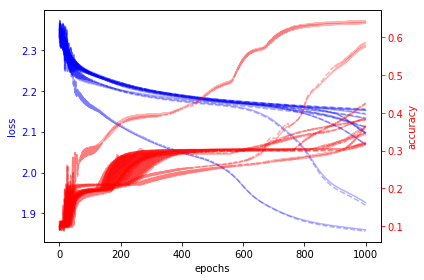

{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': -1.0, 'ro': 1.0, 'epochs': 1000, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
{'train_loss': [2.0981522, 1.8598037, 2.0972087, 2.0696318, 2.1524956, 2.1320481, 2.142518, 1.9266777, 2.152079, 2.1116157], 'test_loss': [2.0958567, 1.856348, 2.0965903, 2.0694723, 2.1548517, 2.13345, 2.1440792, 1.9199136, 2.1544151, 2.1115258], 'train_acc': [0.36553332, 0.6388, 0.38395, 0.42361668, 0.31845, 0.36221668, 0.34635, 0.57708335, 0.32151666, 0.38158333], 'test_acc': [0.3656, 0.6445, 0.3837, 0.4239, 0.3147, 0.3585, 0.3451, 0.5864, 0.3175, 0.3814], 'p_norm': [9.021867, 9.846584, 10.114534, 9.713484, 9.303662, 9.534066, 9.650533, 10.804842, 9.310443, 9.80676], 'hessian_eigens_mean': [0.00027731070725197044, 0.001145880390100042, 0.00036023057598069723, 0.0004742934782541265, 0.00024093688712528604, 0.00041711681272719905, 0.00028724808341206923, 0.000693900211

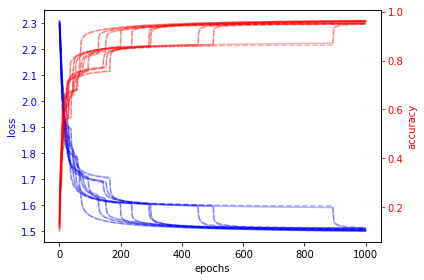

{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 1000, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
{'train_loss': [1.5047472, 1.5046905, 1.5034752, 1.504056, 1.500756, 1.5024818, 1.5104281, 1.5044508, 1.5014114, 1.505233], 'test_loss': [1.5116107, 1.5114384, 1.5118848, 1.5129715, 1.5084484, 1.5099709, 1.5149516, 1.5110682, 1.5093865, 1.5111799], 'train_acc': [0.96001667, 0.9600833, 0.96115, 0.96071666, 0.9640167, 0.96251667, 0.95523334, 0.9605, 0.9635, 0.9598167], 'test_acc': [0.9501, 0.9504, 0.9503, 0.95, 0.9534, 0.9532, 0.9481, 0.9513, 0.9532, 0.9511], 'p_norm': [47.825333, 49.138973, 49.497204, 47.8708, 50.535915, 48.623264, 46.46637, 48.07746, 49.153595, 50.10722], 'hessian_eigens_mean': [0.0016873294400720326, 0.0017111921665068893, 0.001701838092015241, 0.00160867541892186, 0.0017230932003101712, 0.0018907313460738793, 0.00149837807

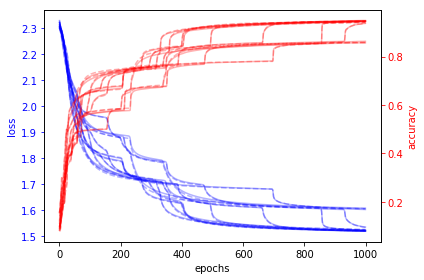

{'optimizer': 'adam', 'train_batch_size': 5000, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 1000, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
{'train_loss': [1.6063523, 1.5175347, 1.6011462, 1.5221446, 1.5209769, 1.533582, 1.5174139, 1.5200553, 1.5189115, 1.5176795], 'test_loss': [1.6046542, 1.5205348, 1.6035165, 1.5245526, 1.5216472, 1.5323775, 1.5182805, 1.5196294, 1.5190427, 1.5201496], 'train_acc': [0.85725, 0.9483, 0.8634667, 0.94443333, 0.9471, 0.93766665, 0.94946665, 0.94695, 0.9469, 0.94801664], 'test_acc': [0.8573, 0.9446, 0.8594, 0.94, 0.9445, 0.9378, 0.9452, 0.9457, 0.9459, 0.9455], 'p_norm': [32.648666, 33.28205, 31.807848, 32.78167, 33.119812, 34.039223, 33.669193, 33.51189, 33.732918, 32.83784], 'hessian_eigens_mean': [0.0009044462145426108, 0.0008882765640223131, 0.0006895240843850405, 0.0010347588945704394, 0.0010369666833597903, 0.0009228427348589027, 0.0010504589

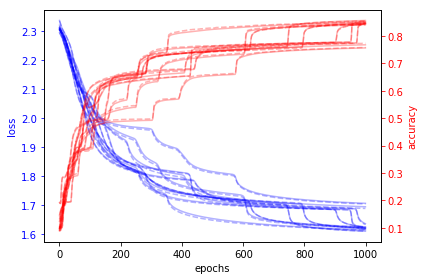

{'optimizer': 'adam', 'train_batch_size': 10000, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 1000, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
{'train_loss': [1.6212592, 1.7072502, 1.6253176, 1.6953074, 1.6254563, 1.6370344, 1.6202489, 1.6217653, 1.6159087, 1.6111033], 'test_loss': [1.6172142, 1.704978, 1.6260903, 1.6894982, 1.6225373, 1.6339837, 1.6206982, 1.624821, 1.6152153, 1.6110017], 'train_acc': [0.85115, 0.7564833, 0.8448333, 0.76771665, 0.84153336, 0.8459333, 0.84671664, 0.8453, 0.85116667, 0.8567167], 'test_acc': [0.8538, 0.7578, 0.8434, 0.7734, 0.8447, 0.8482, 0.8446, 0.8404, 0.8506, 0.8554], 'p_norm': [25.183609, 25.153065, 24.745796, 25.746456, 25.824167, 24.769411, 26.132223, 26.937504, 26.228727, 25.643543], 'hessian_eigens_mean': [0.0006338031590124868, 0.0004982734857422443, 0.0006617427679559675, 0.0005483725021252896, 0.0007233378343361457, 0.0007894496883908623

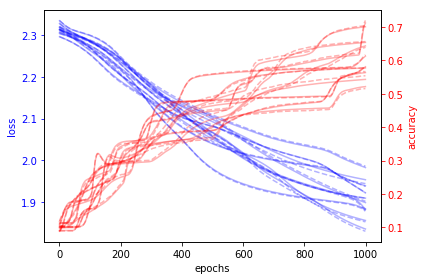

{'optimizer': 'adam', 'train_batch_size': 60000, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 1000, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
{'train_loss': [1.8832885, 1.8980222, 1.9213489, 1.855022, 1.9822681, 1.9529654, 1.9382966, 1.9086577, 1.8344467, 1.8813483], 'test_loss': [1.8801879, 1.9011768, 1.9217037, 1.8516965, 1.9854155, 1.9435623, 1.9371222, 1.9087527, 1.8290098, 1.8762972], 'train_acc': [0.613, 0.6436167, 0.58103335, 0.65416664, 0.52171665, 0.54321665, 0.56375, 0.57746667, 0.70096666, 0.71195], 'test_acc': [0.6169, 0.6399, 0.5821, 0.6567, 0.5158, 0.5542, 0.5667, 0.5784, 0.7042, 0.7199], 'p_norm': [14.406444, 14.918025, 14.127895, 14.537899, 14.211141, 14.419714, 13.829195, 14.629309, 14.920828, 14.726743], 'hessian_eigens_mean': [0.0008636991996016195, 0.0011948726091266643, 0.0010580605688968075, 0.0008879520053572617, 0.0009107771559522554, 0.0008501638423746901

In [25]:
# parameter id -> processed file
params_to_processed = []
done = 0
for param in parameters:
    fs = process_file(get_file(**param), 'loss_decay_' + setting_name + '_' + shorten_dict(param, filename = True), True)
    print(param)
    print(fs)
    print("-----")
    if fs is not None:
        done += 1
    params_to_processed.append(fs)
print('Done: %d/%d' % (done, len(parameters)))

In [26]:
def selection_metric(summary):
    """ Summary of one element in params_to_processed[], a number
    Using mean test accuracy over runs
    """
    return np.mean(summary['test_acc']) if summary is not None else -1

In [27]:
def param_to_result(param):
    """ Parameter setting to results summary """
    idx = parameters.index(param)
    return params_to_processed[idx]

In [28]:
def select_best(optim):
    """ Select best parameters for an optimizer """
    
    metrics = [selection_metric(param_to_result(p)) for p in param_groups[optim]]
    best_idx = np.argmax(metrics)
    return parameters.index(param_groups[optim][best_idx])

In [29]:
def arr_to_stat(arr):
    """ Array -> mean, std """
    return (np.mean(arr), np.std(arr))
def dict_to_stat(d):
    if d is None:
        return None
    """ Dict key-> arr TO key -> mean, std"""
    return {x: arr_to_stat(y) for x, y in d.items()}

In [30]:
def dict_select(d, ks):
    """ Select only keys from ks from dict d """
    return {x: d[x] for x in ks}

In [31]:
# all measured quantities
all_metrics = list(params_to_processed[0].keys())

In [32]:
def subplots(n, m, name, fcn, figsize = (10, 13), figname = None):
    """ Plot many subplots Width m, Height n, fcn: thing to plot """
    fig, axs = plt.subplots(n, m, figsize=figsize)
    axs = axs.ravel()
    i = 0
    while i < len(name):
        fcn(axs[i], i)
        axs[i].set_title(shorten_name(name[i]))
        if i == len(name) - 1 or i == len(name) - 2:
            plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=90)
        else:
            axs[i].set_xticks([])
        i += 1
    while i < n * m:
        fig.delaxes(axs[i])
        i += 1
    plt.show()
    if figname is not None:
        fig.savefig('figures/' + figname + '_' + setting_name + '.eps', bbox_inches = 'tight')
    return fig

In [33]:
# have 7 metrics
print(len(all_metrics))

7


=== OPT sgd / METRIC train_loss ===
=== OPT sgd / METRIC test_loss ===
=== OPT sgd / METRIC train_acc ===
=== OPT sgd / METRIC test_acc ===
=== OPT sgd / METRIC p_norm ===
=== OPT sgd / METRIC hessian_eigens_mean ===
=== OPT sgd / METRIC hessian_eigens_Max ===


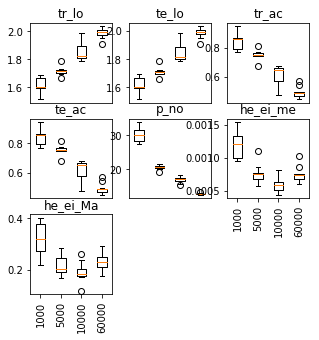

=== OPT frankwolfe_stochastic / METRIC train_loss ===
=== OPT frankwolfe_stochastic / METRIC test_loss ===
=== OPT frankwolfe_stochastic / METRIC train_acc ===
=== OPT frankwolfe_stochastic / METRIC test_acc ===
=== OPT frankwolfe_stochastic / METRIC p_norm ===
=== OPT frankwolfe_stochastic / METRIC hessian_eigens_mean ===
=== OPT frankwolfe_stochastic / METRIC hessian_eigens_Max ===


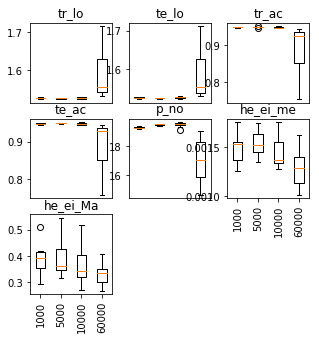

=== OPT frankwolfe_deterministic / METRIC train_loss ===
=== OPT frankwolfe_deterministic / METRIC test_loss ===
=== OPT frankwolfe_deterministic / METRIC train_acc ===
=== OPT frankwolfe_deterministic / METRIC test_acc ===
=== OPT frankwolfe_deterministic / METRIC p_norm ===
=== OPT frankwolfe_deterministic / METRIC hessian_eigens_mean ===
=== OPT frankwolfe_deterministic / METRIC hessian_eigens_Max ===


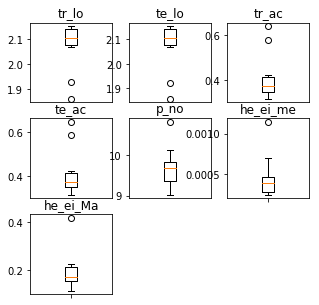

=== OPT adam / METRIC train_loss ===
=== OPT adam / METRIC test_loss ===
=== OPT adam / METRIC train_acc ===
=== OPT adam / METRIC test_acc ===
=== OPT adam / METRIC p_norm ===
=== OPT adam / METRIC hessian_eigens_mean ===
=== OPT adam / METRIC hessian_eigens_Max ===


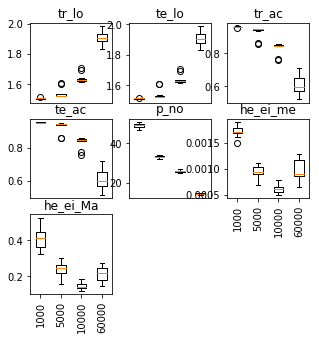

In [34]:
# printing all results (mean over runs/std)
for optim in param_groups.keys():
    data_for_metric = {}
    for m in all_metrics:
        print("=== OPT %s / METRIC %s ===" % (optim, m))
    
        # labels (parameters used)
        xs = []
        
        # values (arrays) for repetitions
        ys = []
    
        # going over parameters
        for p in param_groups[optim]:
            varying_params = dict_select(p, varying[optim])
            #print(varying_params)
            #print(dict_to_stat(param_to_result(p)))
            res = param_to_result(p)
            if res is not None:
                ys.append(res[m])
                xs.append(shorten_dict(varying_params))
        data_for_metric[m] = (xs, ys)
        
    def plot_one(ax, i):
        """ Plot one box plot for metric i at axis ax """
        m = all_metrics[i] # current metric
        xs, ys = data_for_metric[m] # current data
        # plotting
        if xs:
            assert len(xs) == len(ys)
            ax.boxplot(ys, labels = xs)
    subplots(3, 3, all_metrics, plot_one, (5, 5))

### Batch size
Frank-Wolfe:batch size 1000-10K has almost no effect, a bit worse at 60K

Adam/SGD: Increase batch size -> decrease accuracy, increase loss. Hessian becomes a bit worse at 60K, but mostly decreases.

### Big

SGD: With decrease of learning rate, train/test accuracy decreases, loss increases, p-norm decreases and largest eigenvalues decrease. Choising LR=1

Frank-Wolfe Stochastic (g=-1). r = -1 gives best accuracy, constant rs are worse, the more the worse. p-norm decreases with accuracy, eigenvalues also decrease (max/mean). Constant gamma/rho give poor results

Frank-Wolfe deterministic: no data

Adam: with decrease of the learning rate, train accuracy decreases, sharp decrease for 0.0001. Hessian eigenvalues increase. Choosing LR = 0.001

In [35]:
# printing best parameters
for optim in param_groups.keys():
    idx = select_best(optim) # best hyperparameter idx
    p = parameters[idx] # best hyperparameters
    print(optim, dict_select(p, varying[optim]))

sgd {'train_batch_size': 1000}
frankwolfe_stochastic {'train_batch_size': 5000}
frankwolfe_deterministic {}
adam {'train_batch_size': 1000}


In [37]:
# final result for all optimizers (best)
data_for_optimizers = {}

# loop over metrics
for m in all_metrics:
    xs = [] # optimizers
    ys = [] # data for optimizers

    # print final results
    for optim in param_groups.keys():
        idx = select_best(optim) # best hyperparameter
        p = params_to_processed[idx]
        if p is not None:
            xs.append(shorten_name(optim))
            ys.append(p[m])
    
    # saving data...
    data_for_optimizers[m] = (xs, ys)

In [38]:
# https://stackoverflow.com/questions/42656139/set-scientific-notation-with-fixed-exponent-and-significant-digits-for-multiple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)


<Figure size 432x288 with 0 Axes>

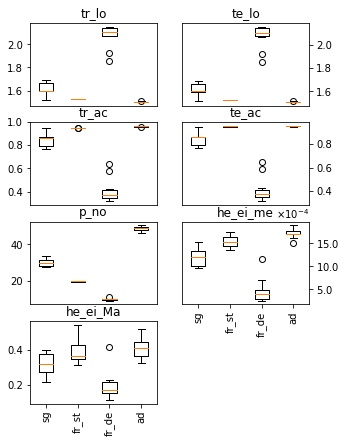

In [39]:
def plot_one(ax, i):
    """ Plot one box plot for metric i at axis ax """
    m = all_metrics[i] # current metric
    xs, ys = data_for_optimizers[m] # current data
    # plotting
    if xs:
        assert len(xs) == len(ys)
        ax.boxplot(ys, labels = xs)
    if i % 2 == 1:
        ax.yaxis.tick_right()
    if m == 'hessian_eigens_mean':
        ax.yaxis.set_major_formatter(OOMFormatter(-4, "%1.1f"))
plt.subplots_adjust(wspace = 1)
subplots(4, 2, all_metrics, plot_one, (5, 7), 'best')
plt.show()

## Batch size
Best accuracy: FW and Adam. Stochastic much better than deterministic for accuracy.

Hessian is a bit better for FW than for Adam

### Big

SGD: high variance, low Hessian

FW: high accuracy (a bit lower than Adam), low p-norm, high Hessian, hood generalization

Adam: highest accuracy, low variance, high p-norm, low Hessian, good generalization